### Variational Quantum Approach for the 1D Viscous Bergers Equation
#### Hardware

In [1]:
# Imports

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter
from qiskit.visualization import circuit_drawer, plot_histogram, plot_state_city
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import circuit_drawer
%matplotlib inline

In [2]:

your_api_key = "iaKV5L7U_7Dvf4JIokwNYFyebtbWHF3sP3pblTXDc7wA"
your_crn = "crn:v1:bluemix:public:quantum-computing:us-east:a/8f99915aec1d4742b2a6a9408b74a1af:34e7f6c4-5c0d-4477-8c3e-644c5db6084a::"

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token=your_api_key,
    instance=your_crn,
    name="proj",
    overwrite=True
)

In [3]:
#Parameters and initialization

# ====================== PARAMETERS ======================
nu = 0.01
L = 1.0
T_max = 1.0
n_x = 2
n_t = 2
depth = 3
Nx = 4
Nt = 4
eta1 = 50
eta2 = 50

n_qubits = 1 + n_x + n_t
total_basis = 2**(n_qubits - 1)

x_grid = np.linspace(0, L, Nx)
t_grid = np.linspace(0, T_max, Nt)
X, T = np.meshgrid(x_grid, t_grid, indexing='ij')

In [4]:
#Chebyshev Basis calculation

def compute_chebyshev(k, x, a=-1, b=1):
    x_mapped = 2*(x - a)/(b - a) - 1 if b != a else 0

    T = np.zeros(k+1)
    dT = np.zeros(k+1)
    d2T = np.zeros(k+1)

    if k >= 0:
        T[0] = 1
    if k >= 1:
        T[1] = x_mapped
        dT[1] = 1

    for i in range(2, k+1):
        T[i] = 2 * x_mapped * T[i-1] - T[i-2]
        dT[i] = 2 * T[i-1] + 2 * x_mapped * dT[i-1] - dT[i-2]
        d2T[i] = 4 * dT[i-1] + 2 * x_mapped * d2T[i-1] - d2T[i-2]

    scale = 2 / (b - a) if b != a else 1
    dT *= scale
    d2T *= scale**2

    return T, dT, d2T


In [5]:
#Precompute basis values

basis_vals = {}
for i, x in enumerate(x_grid):
    for j, t in enumerate(t_grid):
        key = (i, j)
        basis_vals[key] = {
            'T': np.zeros(total_basis),
            'dT_dx': np.zeros(total_basis),
            'dT_dt': np.zeros(total_basis),
            'd2T_dx2': np.zeros(total_basis),
        }

        Tx, dTx, d2Tx = compute_chebyshev(2**n_x - 1, x, a=0, b=L)
        Tt, dTt, d2Tt = compute_chebyshev(2**n_t - 1, t, a=0, b=T_max)

        for idx in range(total_basis):
            kx = idx // (2**n_t)
            kt = idx % (2**n_t)
            basis_vals[key]['T'][idx] = Tx[kx] * Tt[kt]
            basis_vals[key]['dT_dx'][idx] = dTx[kx] * Tt[kt]
            basis_vals[key]['dT_dt'][idx] = Tx[kx] * dTt[kt]
            basis_vals[key]['d2T_dx2'][idx] = d2Tx[kx] * Tt[kt]

In [6]:
# Quantum circuit of VQC

def vqc(theta):
    qc = QuantumCircuit(n_qubits,n_qubits)
    
    # Initial layer
    for wire in range(n_qubits):
        qc.ry(theta[wire], wire)
    
    param_idx = n_qubits
    for _ in range(depth):
        for wire in range(n_qubits - 1):
            qc.cx(wire, wire + 1)
        qc.cx(n_qubits - 1, 0)

        for wire in range(n_qubits):
            qc.ry(theta[param_idx], wire)
            param_idx += 1
    
    qc.measure_all()

    return qc

In [7]:
#State vector prediction
from qiskit_ibm_runtime import Options, SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name="proj")
service.saved_accounts()

def get_hardware_samples(theta, backend, shots=1024):
    qc = vqc(theta)  # Use your updated vqc function
    qc = transpile(qc, backend)
    
    # Direct execution without Session (for open plan)
    sampler = Sampler(mode=backend)
    job = sampler.run([qc], shots=shots)
    result = job.result()
    counts = result[0].data.meas.get_counts()
    
    return counts

def u_pred_hardware(i, j, params, backend, shots=1024):
    theta = params[:-1]
    lam = params[-1]
    
    # Get measurement counts from hardware
    counts = get_hardware_samples(theta, backend, shots)
    
    # Convert counts to probabilities
    total_shots = sum(counts.values())
    prob = np.zeros(2**n_qubits)
    
    for bitstring, count in counts.items():
        idx = int(bitstring, 2)
        prob[idx] = count / total_shots
    
    # Calculate expectation value
    key = (i, j)
    u_val = 0
    for idx in range(total_basis):
        u_val += prob[idx] * basis_vals[key]['T'][idx]
        u_val -= prob[idx + total_basis] * basis_vals[key]['T'][idx]
    
    return lam * u_val

In [8]:
def pde_residual_hardware(i, j, params, backend, shots=1024):
    theta = params[:-1]
    lam = params[-1]
    
    # Get measurement counts from hardware
    counts = get_hardware_samples(theta, backend, shots)
    
    # Convert counts to probabilities
    total_shots = sum(counts.values())
    prob = np.zeros(2**n_qubits)
    
    for bitstring, count in counts.items():
        idx = int(bitstring, 2)
        prob[idx] = count / total_shots
    
    key = (i, j)
    
    # Calculate all derivatives using hardware probabilities
    u = lam * sum(prob[idx] * basis_vals[key]['T'][idx] -
                  prob[idx + total_basis] * basis_vals[key]['T'][idx]
                  for idx in range(total_basis))
    
    u_x = lam * sum(prob[idx] * basis_vals[key]['dT_dx'][idx] -
                    prob[idx + total_basis] * basis_vals[key]['dT_dx'][idx]
                    for idx in range(total_basis))
    
    u_t = lam * sum(prob[idx] * basis_vals[key]['dT_dt'][idx] -
                    prob[idx + total_basis] * basis_vals[key]['dT_dt'][idx]
                    for idx in range(total_basis))
    
    u_xx = lam * sum(prob[idx] * basis_vals[key]['d2T_dx2'][idx] -
                     prob[idx + total_basis] * basis_vals[key]['d2T_dx2'][idx]
                     for idx in range(total_basis))
    
    return u_t + u * u_x - nu * u_xx

In [9]:
def loss_function_hardware(params, backend, shots=1024):
    total_loss = 0.0
    
    # 1. Initial condition (t = 0)
    ic_loss = 0.0
    for i in range(Nx):
        u_pred_val = u_pred_hardware(i, 0, params, backend, shots)
        u_true = 1.0 if x_grid[i] <= 0.5 else 0.0
        ic_loss += (u_pred_val - u_true)**2
    total_loss += eta1 * ic_loss / Nx
    
    # 2. Boundary condition loss
    bc_loss = 0.0
    for j in range(Nt):
        u_pred_left = u_pred_hardware(0, j, params, backend, shots)
        u_pred_right = u_pred_hardware(Nx - 1, j, params, backend, shots)
        bc_loss += (u_pred_left - 1.0)**2
        bc_loss += (u_pred_right - 0.0)**2
    total_loss += eta2 * bc_loss / (2 * Nt)
    
    # 3. PDE residual loss
    pde_loss = 0.0
    for i in range(1, Nx - 1):
        for j in range(1, Nt):
            res = pde_residual_hardware(i, j, params, backend, shots)
            pde_loss += res**2
    total_loss += pde_loss / ((Nx - 2) * (Nt - 1))
    
    return total_loss

In [10]:
# Optimization
num_params = n_qubits * (depth + 1) + 1  # +1 for lambda scaling
init_params = np.random.uniform(0, 2 * np.pi, num_params)

# Setup hardware backend
  # Add your credentials
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=n_qubits)

# Create wrapper function for hardware optimization
def objective_function(params):
    return loss_function_hardware(params, backend, shots=1024)

print("Optimizing...")
result = minimize(objective_function, init_params, method='COBYLA', options={'maxiter': 50})
opt_params = result.x
print(f"Optimization complete! Final loss: {result.fun:.6f}")

Optimizing...
Optimization complete! Final loss: 25.707538


In [11]:
#Solution grid and visualization

U = np.zeros((Nx, Nt))
for i in range(Nx):
    for j in range(Nt):
        U[i, j] = u_pred_hardware(i, j, opt_params, backend, shots=1024)


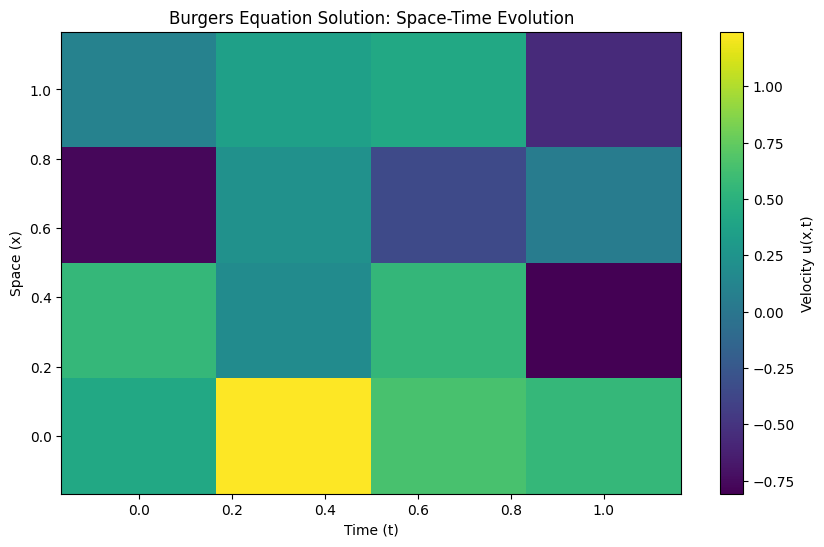

In [12]:
# Heatmap

plt.figure(figsize=(10, 6))
plt.pcolormesh(t_grid, x_grid, U, shading='auto', cmap='viridis')
plt.colorbar(label='Velocity u(x,t)')
plt.xlabel('Time (t)')
plt.ylabel('Space (x)')
plt.title('Burgers Equation Solution: Space-Time Evolution')
plt.savefig('burgers_2d.png')
plt.show()

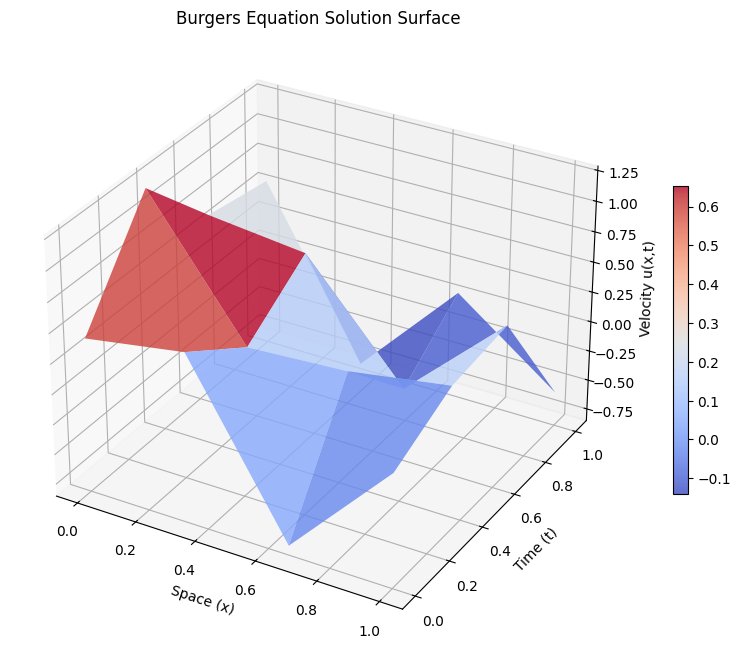

In [13]:
#3D Surface plot

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
T_mesh, X_mesh = np.meshgrid(t_grid, x_grid)
surf = ax.plot_surface(X_mesh, T_mesh, U, cmap='coolwarm', rstride=1, cstride=1, alpha=0.8)
ax.set_xlabel('Space (x)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Velocity u(x,t)')
ax.set_title('Burgers Equation Solution Surface')
fig.colorbar(surf, ax=ax, shrink=0.5)
plt.savefig('burgers_3d.png')
plt.show()

Saved burgers_evolution.gif


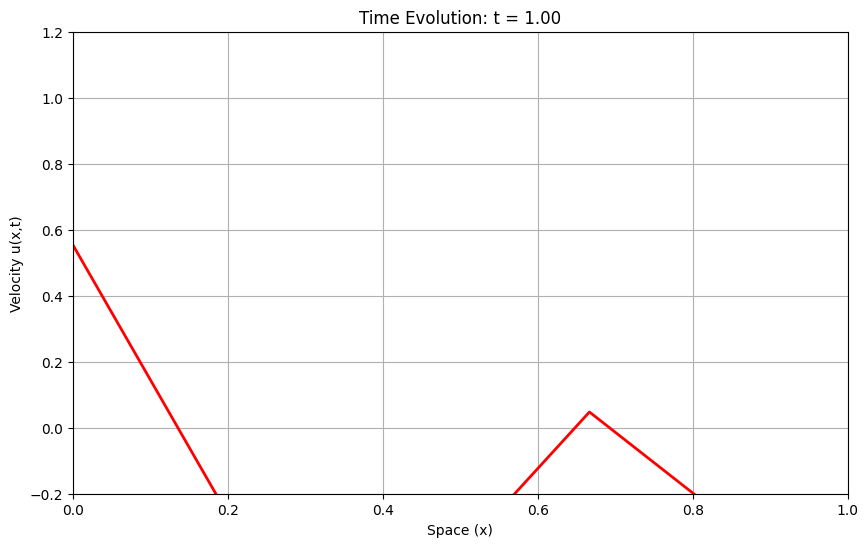

In [14]:
# Time slice animation

fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], 'r-', linewidth=2)
ax.set_xlim(0, L)
ax.set_ylim(-0.2, 1.2)
ax.set_xlabel('Space (x)')
ax.set_ylabel('Velocity u(x,t)')
ax.grid(True)
ax.set_title('Burgers Equation Time Evolution')

def init():
    line.set_data([], [])
    return line,

def animate(j):
    u_slice = U[:, j]
    line.set_data(x_grid, u_slice)
    ax.set_title(f'Time Evolution: t = {t_grid[j]:.2f}')
    return line,

ani = FuncAnimation(fig, animate, frames=Nt, init_func=init, blit=True, interval=200)
ani.save('burgers_evolution.gif', writer='pillow', fps=5)
print("Saved burgers_evolution.gif")

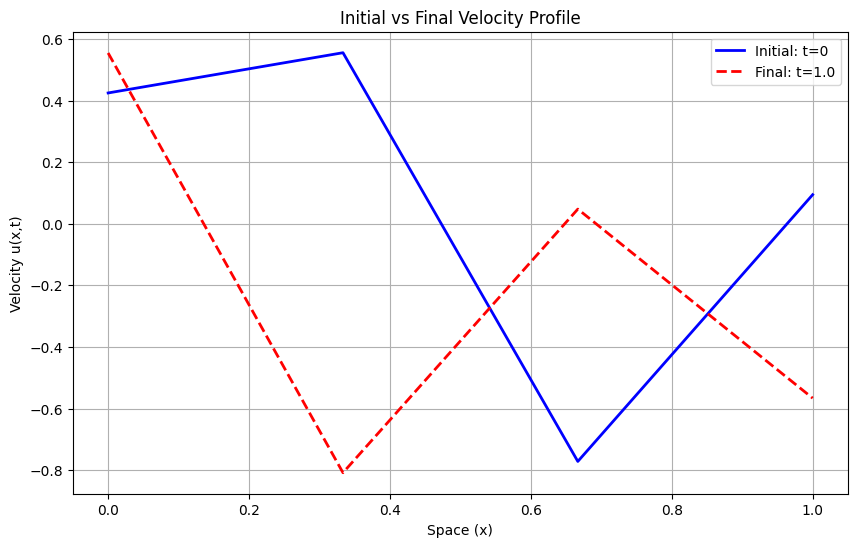

All visualizations saved!


In [15]:
#Initial and final state

plt.figure(figsize=(10, 6))
plt.plot(x_grid, U[:, 0], 'b-', label='Initial: t=0', linewidth=2)
plt.plot(x_grid, U[:, -1], 'r--', label=f'Final: t={T_max:.1f}', linewidth=2)
plt.xlabel('Space (x)')
plt.ylabel('Velocity u(x,t)')
plt.legend()
plt.grid(True)
plt.title('Initial vs Final Velocity Profile')
plt.savefig('burgers_comparison.png')
plt.show()

print("All visualizations saved!")